In [1]:
import matplotlib.pyplot as plt
from models.mini_vgg import MiniVGG
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from trustscore import TrustScore
from utils import create_dataset, plot_precision_curve, run_model, run_precision_plt
assert tf.__version__.startswith('2')

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
BATCH_SIZE = 64
EPOCHS = 60

In [5]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

train_features = train_features.reshape(-1, 28, 28, 1)
train_features = train_features.astype('float32')
train_features = train_features / 255.

test_features = test_features.reshape(-1, 28, 28, 1)
test_features = test_features.astype('float32')
test_features = test_features / 255.

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [6]:
validation_features, test_features, validation_labels, test_labels = train_test_split(test_features,
                                                                                      test_labels,
                                                                                      test_size=0.50,
                                                                                      stratify=test_labels)

In [7]:
pca = PCA(n_components=64)
enc_train_features = pca.fit_transform(train_features.reshape(-1, 784))
enc_test_features = pca.transform(test_features.reshape(-1, 784))

In [8]:
train_dataset = create_dataset(train_features, train_labels, batch_size)
validation_dataset = create_dataset(validation_features, validation_labels, (batch_size // 4))
test_dataset = create_dataset(test_features, test_labels, (batch_size // 4))

In [9]:
model = MiniVGG(input_shape=(28, 28, 1), num_classes=10)

In [10]:
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [11]:
model(train_features[0].reshape(1, 28, 28, 1))

<tf.Tensor: id=236, shape=(1, 10), dtype=float32, numpy=
array([[0.09867114, 0.10123584, 0.09676384, 0.10114217, 0.10354413,
        0.10128273, 0.09387478, 0.09866307, 0.10058797, 0.10423434]],
      dtype=float32)>

In [12]:
model.summary()

Model: "mini_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0  

In [13]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    verbose=2)

Epoch 1/60
937/937 - 7s - loss: 0.1928 - accuracy: 0.9379 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/60
937/937 - 6s - loss: 0.0630 - accuracy: 0.9814 - val_loss: 0.0275 - val_accuracy: 0.9914
Epoch 3/60
937/937 - 5s - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.0209 - val_accuracy: 0.9938
Epoch 4/60
937/937 - 6s - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0165 - val_accuracy: 0.9946
Epoch 5/60
937/937 - 7s - loss: 0.0321 - accuracy: 0.9906 - val_loss: 0.0173 - val_accuracy: 0.9946
Epoch 6/60
937/937 - 6s - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0171 - val_accuracy: 0.9948
Epoch 7/60
937/937 - 6s - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0185 - val_accuracy: 0.9928
Epoch 8/60
937/937 - 5s - loss: 0.0228 - accuracy: 0.9934 - val_loss: 0.0195 - val_accuracy: 0.9944
Epoch 9/60
937/937 - 6s - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0162 - val_accuracy: 0.9948
Epoch 10/60
937/937 - 6s - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.0166 - val_accuracy

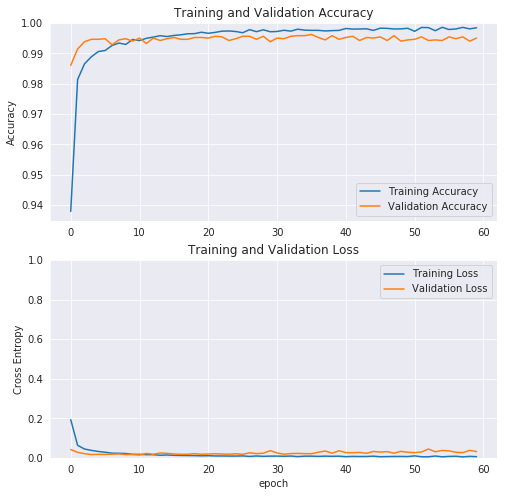

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

sns.set_style('dark')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [15]:
score = model.evaluate(test_dataset)
print('test accuracy : {}'.format(score[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0280 - accuracy: 0.9950
test accuracy : 0.9950000047683716


In [16]:
ts = TrustScore(alpha=5e-2)
ts.fit(enc_train_features, train_labels)

In [17]:
predictions = model.predict(test_features)

In [18]:
trust_scores, closest_classes,\
_, _, _, _ = ts.score(enc_test_features, predictions, k=5)

In [19]:
num_samples = 5
index_min = np.argsort(trust_scores)[:num_samples]
index_max = np.argsort(trust_scores)[-num_samples:]
score_min = trust_scores[index_min]
score_max = trust_scores[index_max]
closest_min = closest_classes[index_min]
closest_max = closest_classes[index_max]
prediction_min = tf.argmax(predictions[index_min], 1)
prediction_max = tf.argmax(predictions[index_max], 1)
likelihood_min = tf.math.reduce_max(predictions[index_min], 1)
likelihood_max = tf.math.reduce_max(predictions[index_max], 1)
label_min = tf.argmax(test_labels[index_min], 1)
label_max = tf.argmax(test_labels[index_max], 1)
features_min = test_features[index_min]
features_max = test_features[index_max]

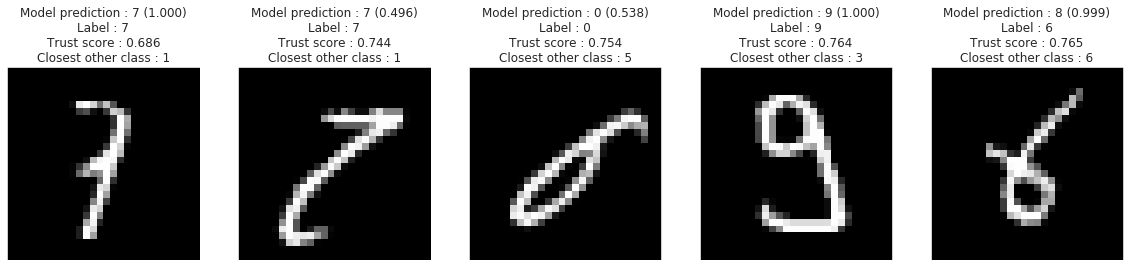

In [20]:
plt.figure(figsize=(20, 4))

for index in range(num_samples):
    axis = plt.subplot(1, num_samples, index + 1)
    plt.imshow(features_min[index].reshape(28, 28), cmap='gray')
    plt.title('Model prediction : {} ({:.3f})\nLabel : {}\nTrust score : {:.3f}' \
              '\nClosest other class : {}'.format(prediction_min.numpy()[index],
                                                  likelihood_min[index],
                                                  label_min.numpy()[index],
                                                  score_min[index],
                                                  closest_min[index]))
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
plt.show()

In [21]:
print(index_min)

[3423 3465  572 1967 4556]


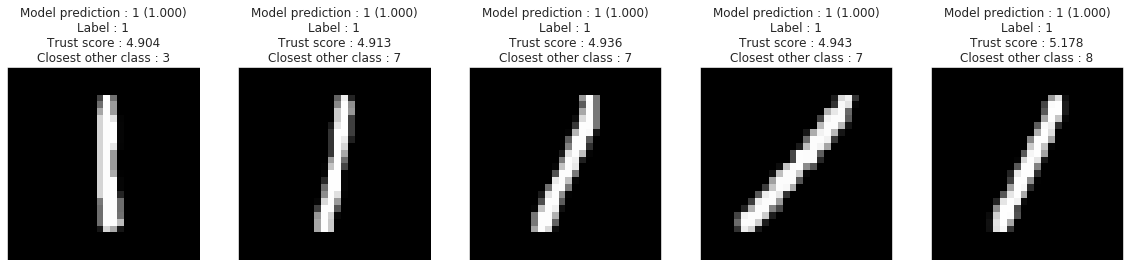

In [22]:
plt.figure(figsize=(20, 4))

for index in range(num_samples):
    axis = plt.subplot(1, num_samples, index + 1)
    plt.imshow(features_max[index].reshape(28, 28), cmap='gray')
    plt.title('Model prediction : {} ({:.3f})\nLabel : {}\nTrust score : {:.3f}' \
              '\nClosest other class : {}'.format(prediction_max.numpy()[index],
                                                  likelihood_max[index],
                                                  label_max.numpy()[index],
                                                  score_max[index],
                                                  closest_max[index]))
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
plt.show()

In [23]:
print(index_max)

[3910 4908 4109 3768 2104]


In [24]:
model.save_weights('saved_model/mnist/mini-vgg/2', save_format='tf')

In [25]:
percentiles = [0 + 0.5 * index for index in range(200)]
num_fold = 5
plt_names = ['Model Confidence', 'Trust Score']

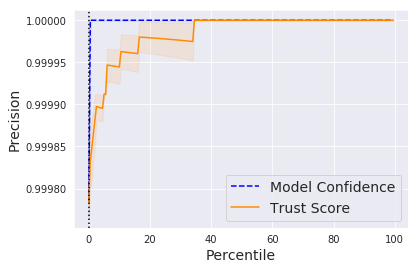

In [26]:
run_precision_plt(train_features,
                  train_labels,
                  num_fold,
                  percentiles,
                  run_model,
                  plt_title='',
                  plt_names=plt_names,
                  predict_correct=True,
                  model=model)

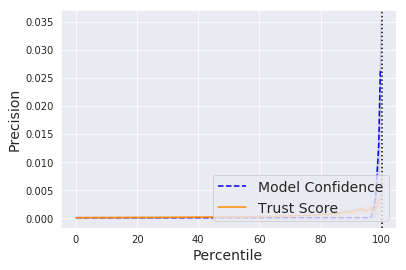

In [27]:
run_precision_plt(train_features,
                  train_labels,
                  num_fold,
                  percentiles,
                  run_model,
                  plt_title='',
                  plt_names=plt_names,
                  predict_correct=False,
                  model=model)